# Password strength classifier with deep learning

This notebook addresses the [challenge](https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset) proposed by Bhakiv Bansal in Kaggle's dataset repository. There is a collection of 670k password strings from a published leak which have been consensually classified as weak, medium or strong through three production algorithms (by Twitter, Microsoft and Battle). In this exercise we will develop a deep learning solution (with Keras) to classify the strength of these passwords in the same way as the aforementioned algorithms. We will assign 90% of the dataset to train our model and 10% as a validation subset.

### 1. Loading and cleaning the dataset
The original CSV comes with some lines having more than two values, filled with non-relevant information, so trying to load it with Pandas will return an error if the extra values are not cleaned before. After dealing with these, we can start with the usual imports for data handling and visualization, as well as regex to produce some new variables on which we will build the classification. 

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data2.csv", sep= ";", encoding ="ISO-8859-1")
df

,password,strength
0,kzde5577,1.0
1,kino3434,1.0
2,visi7k1yr,1.0
3,megzy123,1.0
4,lamborghin1,1.0
...,...,...
669873,10redtux10,1.0
669874,infrared1,1.0
669875,184520socram,1.0
669876,marken22a,1.0


In [34]:
df.duplicated().sum()

236

In [35]:
df.isna().sum()

password      1
strength    239
dtype: int64

We'll take an easy approach for dealing with duplicate lines and NaN values, as they are in very low numbers relative to the whole dataset, and just drop them when present.

In [36]:
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669638 entries, 0 to 669877
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   password  669638 non-null  object 
 1   strength  669638 non-null  float64
dtypes: float64(1), object(1)
memory usage: 15.3+ MB


### 2. Exploration and strategy
The dataframe looks clean and ready to be explored, so we'll take a look at the distribution of values in the only numerical feature we got so far, "strength".

In [37]:
df["strength"].value_counts().sort_index()

0.0     89701
1.0    496801
2.0     83136
Name: strength, dtype: int64

There is a big imbalance in the values in the "strength" feature, so we should take care to preserve this distribution when we later split the dataset for training, testing and validating.

For the other feature, "password", we can expect strings of different lengths containing a mix of all kind of characters: letters, digits and specials. To turn the feature into useful information, we will produce counts of the different kinds of contents:
- Count of total characters.
- Count of lower case letters.
- Count of higher case letters.
- Count of digits.
- Count of special characters.

This will deliver five new numerical, discrete features with relatively close ranges of values, very conveninent for feeding a neural network.

### 3. Transformations
One at a time, we'll start by running a function to return the count of total characters in the passwords as a new feature of the dataframe.

In [38]:
def counter (input):
    return len(str(input))

df["length"] = df["password"].apply(counter)
df.head()

,password,strength,length
0,kzde5577,1.0,8
1,kino3434,1.0,8
2,visi7k1yr,1.0,9
3,megzy123,1.0,8
4,lamborghin1,1.0,11


Next, three functions to count all the lower case letters, higher case letters and digits, based on regex searches.

In [39]:
def count_lower(input):
    return len(re.findall("[a-z]", str(input)))

def count_higher(input):
    return len(re.findall("[A-Z]", str(input)))

def count_numbers(input):
    return len(re.findall("\d", str(input)))

df["lower"] = df["password"].apply(count_lower)
df["higher"] = df["password"].apply(count_higher)
df["numbers"] = df["password"].apply(count_numbers)
df.head()

,password,strength,length,lower,higher,numbers
0,kzde5577,1.0,8,4,0,4
1,kino3434,1.0,8,4,0,4
2,visi7k1yr,1.0,9,7,0,2
3,megzy123,1.0,8,5,0,3
4,lamborghin1,1.0,11,10,0,1


Finally, we will consider anything not a letter or digit to be a special character, so their count will come from the difference from the total count.

In [41]:
df["special"] = df.apply(lambda f: f.length - f.lower - f.higher - f.numbers, axis=1)
df.head()

,password,strength,length,lower,higher,numbers,special
0,kzde5577,1.0,8,4,0,4,0
1,kino3434,1.0,8,4,0,4,0
2,visi7k1yr,1.0,9,7,0,2,0
3,megzy123,1.0,8,5,0,3,0
4,lamborghin1,1.0,11,10,0,1,0


Checking the distribution of values in the new features we can appreciate how skewed they are towards the lower end, while also showing some infrequent very high values which are obviously tagged as outliers in the boxplots.

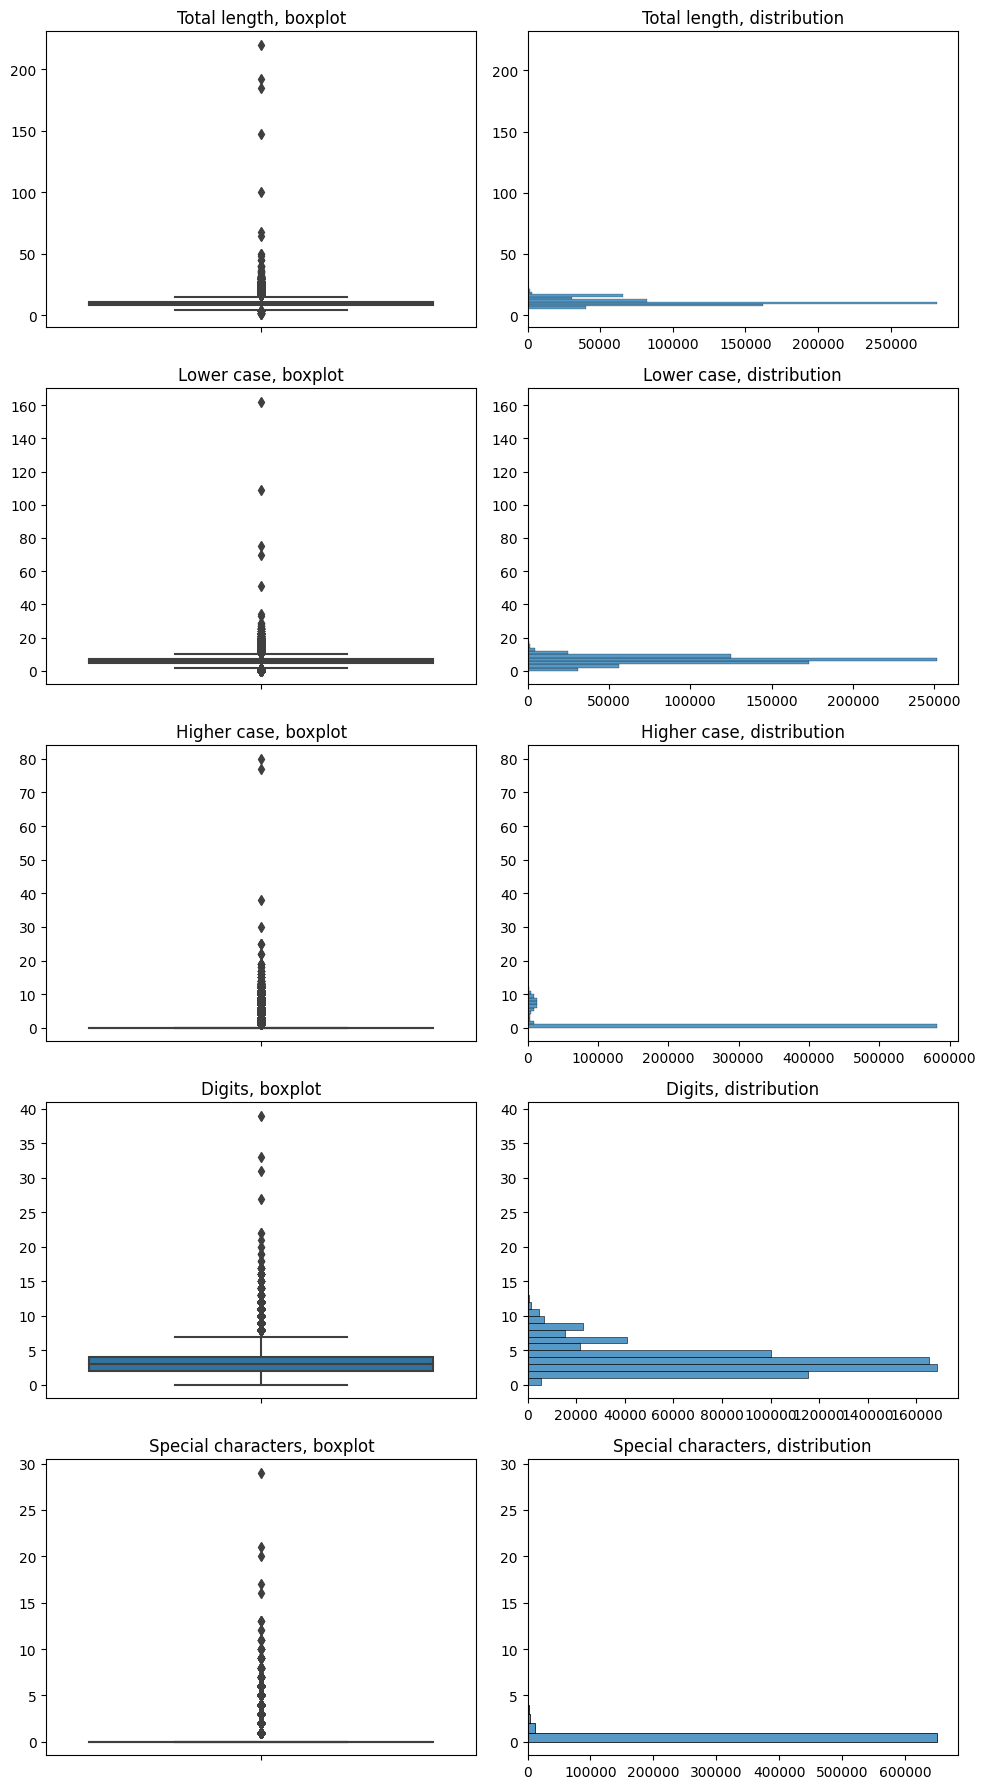

In [60]:
figure, axes = plt.subplots(5, 2, figsize=(10,18))
p00 = sns.boxplot(ax=axes[0, 0], data=df, y="length");
p00.set_title("Total length, boxplot")
p00.set(xlabel=None)
p00.set(ylabel=None)
p01 = sns.histplot(ax= axes[0, 1], data=df, y="length", binwidth=2);
p01.set_title("Total length, distribution")
p01.set(xlabel=None)
p01.set(ylabel=None)
p10 = sns.boxplot(ax=axes[1, 0], data=df, y="lower");
p10.set_title("Lower case, boxplot")
p10.set(xlabel=None)
p10.set(ylabel=None)
p11 = sns.histplot(ax=axes[1, 1], data=df, y="lower", binwidth=2);
p11.set_title("Lower case, distribution")
p11.set(xlabel=None)
p11.set(ylabel=None)
p20 = sns.boxplot(ax=axes[2, 0], data=df, y="higher");
p20.set_title("Higher case, boxplot")
p20.set(xlabel=None)
p20.set(ylabel=None)
p21 = sns.histplot(ax=axes[2, 1], data=df, y="higher", binwidth=1);
p21.set_title("Higher case, distribution")
p21.set(xlabel=None)
p21.set(ylabel=None)
p30 = sns.boxplot(ax=axes[3, 0], data=df, y="numbers");
p30.set_title("Digits, boxplot")
p30.set(xlabel=None)
p30.set(ylabel=None)
p31 = sns.histplot(ax=axes[3, 1], data=df, y="numbers", binwidth=1);
p31.set_title("Digits, distribution")
p31.set(xlabel=None)
p31.set(ylabel=None)
p40 = sns.boxplot(ax=axes[4, 0], data=df, y="special");
p40.set_title("Special characters, boxplot")
p40.set(xlabel=None)
p40.set(ylabel=None)
p41 = sns.histplot(ax=axes[4, 1], data=df, y="special", binwidth=1);
p41.set_title("Special characters, distribution")
p41.set(xlabel=None)
p41.set(ylabel=None)
plt.tight_layout()

With this scenario, applying a Robust Scaler transformation will help to bring the ranges of the features closer, thus helping the model to get a better fit.

In [64]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df[["length_sc", "lower_sc", "higher_sc", "numbers_sc", "special_sc"]] = scaler.fit_transform(df[["length", "lower", "higher", "numbers", "special"]])
df[["length_sc", "lower_sc", "higher_sc", "numbers_sc", "special_sc"]].describe()

,length_sc,lower_sc,higher_sc,numbers_sc,special_sc
count,669638.000000,669638.000000,669638.000000,669638.000000,669638.000000
mean,0.330547,-0.015473,0.793975,0.090950,0.046712
std,0.939983,1.189647,2.285071,1.000722,0.344019
min,-2.666667,-3.000000,0.000000,-1.500000,0.000000
25%,-0.333333,-0.500000,0.000000,-0.500000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.500000,0.000000,0.500000,0.000000
max,70.333333,78.000000,80.000000,18.000000,29.000000


### 4. Setting up the neural network
The features are ready for feeding, so we can start building the structure of the neural network. For convenience, we define first the set of X features as well as the y feature; the later will require dummification, for which we will call the proper transformer from Keras utilities.

In [65]:
X = df[["length_sc", "lower_sc", "higher_sc", "numbers_sc", "special_sc"]]

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from keras.utils import np_utils

y = df["strength"]
nclasses = len(y.unique())
y = np_utils.to_categorical(y, nclasses)
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

We need a very simple network for this job, as we are feeding only 5 features for which we have over 670k samples; in fact the ratio is great to aim for very high precision. One hidden layer will be enough.<br>
After some testing, an optimal output was found for a hidden layer with 10 nodes, twice the nodes in the input layer; this achieved a higher precision than the 4-node hidden layer that convention would suggest for our 1-hidden layer network (i.e. an amount of nodes between those in the input and output layers).

In [68]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

input_dim = X.shape[1]
output_dim = y.shape[1]

model = Sequential()
model.add(Dense(10, input_dim=input_dim))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(output_dim))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                60        
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
 activation_3 (Activation)   (None, 3)                 0         
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


### 5. Training the network
The dataset is partitioned first into 90% training and 10% validation, then the training subset into 80% proper training and 20% testing, always preserving the distribution of values in the target feature. After this is done the model can be compiled and then trained for the number of epochs passed.

In [69]:
X_main, X_val, y_main, y_val = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=10, stratify=y_main)

from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
num_epochs = 200
batch_size = 512
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
network = model.fit(X_train, y_train, callbacks=callback, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_test,y_test))

Epoch 1/200
942/942 [==============================] - 5s 2ms/step - loss: 0.4989 - accuracy: 0.8218 - val_loss: 0.2485 - val_accuracy: 0.9013
Epoch 2/200
942/942 [==============================] - 2s 2ms/step - loss: 0.2472 - accuracy: 0.9444 - val_loss: 0.1455 - val_accuracy: 0.9836
Epoch 3/200
942/942 [==============================] - 2s 2ms/step - loss: 0.1898 - accuracy: 0.9513 - val_loss: 0.1038 - val_accuracy: 0.9875
Epoch 4/200
942/942 [==============================] - 2s 2ms/step - loss: 0.1585 - accuracy: 0.9540 - val_loss: 0.0807 - val_accuracy: 0.9903
Epoch 5/200
942/942 [==============================] - 2s 2ms/step - loss: 0.1386 - accuracy: 0.9589 - val_loss: 0.0655 - val_accuracy: 0.9918
Epoch 6/200
942/942 [==============================] - 2s 2ms/step - loss: 0.1249 - accuracy: 0.9628 - val_loss: 0.0548 - val_accuracy: 0.9931
Epoch 7/200
942/942 [==============================] - 2s 2ms/step - loss: 0.1136 - accuracy: 0.9666 - val_loss: 0.0467 - val_accuracy: 0.9937

Epoch 58/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0396 - accuracy: 0.9884 - val_loss: 0.0057 - val_accuracy: 0.9993
Epoch 59/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0394 - accuracy: 0.9884 - val_loss: 0.0056 - val_accuracy: 0.9993
Epoch 60/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0393 - accuracy: 0.9884 - val_loss: 0.0056 - val_accuracy: 0.9993
Epoch 61/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0381 - accuracy: 0.9887 - val_loss: 0.0055 - val_accuracy: 0.9993
Epoch 62/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0055 - val_accuracy: 0.9994
Epoch 63/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0375 - accuracy: 0.9884 - val_loss: 0.0054 - val_accuracy: 0.9994
Epoch 64/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0366 - accuracy: 0.9886 - val_loss: 0.0054 - val_accuracy:

Epoch 115/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0182 - accuracy: 0.9928 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 116/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0181 - accuracy: 0.9930 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 117/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0185 - accuracy: 0.9927 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 118/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0186 - accuracy: 0.9926 - val_loss: 0.0016 - val_accuracy: 0.9999
Epoch 119/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0179 - accuracy: 0.9928 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 120/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0180 - accuracy: 0.9928 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 121/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0182 - accuracy: 0.9926 - val_loss: 0.0015 - val_ac

Epoch 171/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 8.2270e-04 - val_accuracy: 1.0000
Epoch 172/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 8.0189e-04 - val_accuracy: 1.0000
Epoch 173/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 7.8991e-04 - val_accuracy: 1.0000
Epoch 174/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 7.7572e-04 - val_accuracy: 1.0000
Epoch 175/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 7.5899e-04 - val_accuracy: 1.0000
Epoch 176/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 7.6981e-04 - val_accuracy: 1.0000
Epoch 177/200
942/942 [==============================] - 2s 2ms/step - loss: 0.0153 - accuracy: 0.9949 - v

The training halted after 192 epochs thanks to the callback function passed, although 100% accuracy was achieved quite earlier, so the callback function could have been more relaxed.

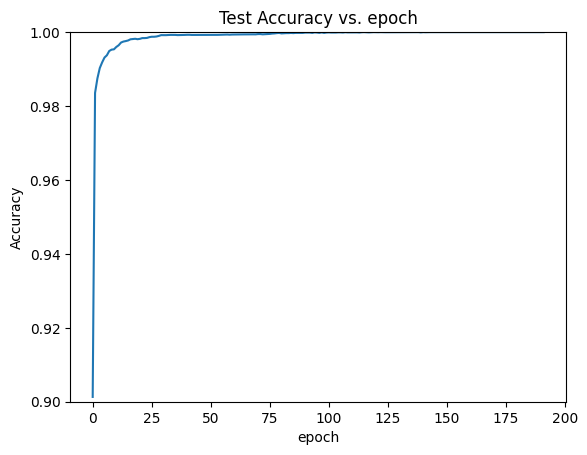

In [70]:
plt.plot(network.history['val_accuracy'])
plt.title('Test Accuracy vs. epoch')
plt.ylabel('Accuracy')
plt.ylim(0.9,1)
plt.xlabel('epoch')
plt.show()

### 6. Testing the output
The only step left is to check how the classification of our validation subset fares, which can be visualized through a confusion matrix.

131/131 [==============================] - 0s 2ms/step - loss: 6.9361e-04 - accuracy: 1.0000
Test loss: 0.00 Accuracy: 1.00


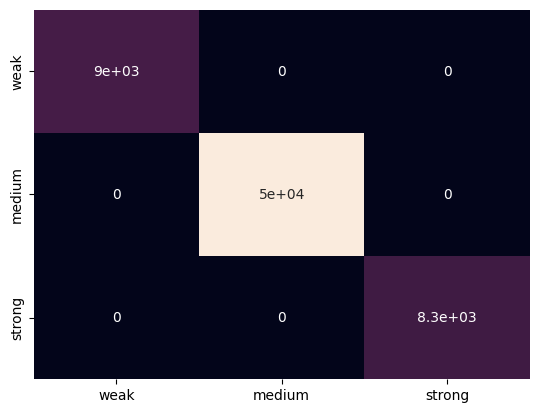

In [72]:
from sklearn.metrics import confusion_matrix

categories = ["weak", "medium", "strong"]
predict = model.predict(X_val)
confusion = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(predict, axis=1))
ax = sns.heatmap(confusion, annot=True, cbar=False);
ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)
plt.show;

test_loss, test_accuracy = model.evaluate(X_val, y_val, batch_size=batch_size)
print("Test loss: %.2f Accuracy: %.2f" % (test_loss, test_accuracy))

The network yielded a perfect classification for the 67k samples in the validation subset.